In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.signal import convolve2d
from scipy.linalg import orth

# The 1D Gaussian derivative basis.

We will use the fact that the $o$-th order derivative of the 1D Gaussian can be generated by multiplying the $o$-th Hermite polynomial by a Gaussian envelope (plus some extra normalization). First, the Hermite polynomials of any order: 

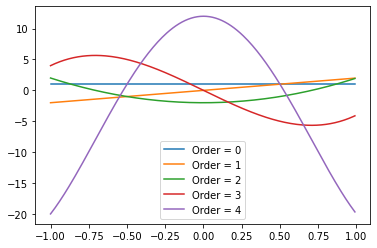

In [2]:
def hermite(n, x):
    if n == 0:
        return np.ones(x.shape)
    elif n == 1:
        return 2.0 * x
    else:
        return 2.0 * x * hermite(n - 1, x) - 2.0 * (n - 1) * hermite(n - 2, x)


# Some tests.
rng = np.arange(-1, 1, 0.01)
for n in range(5):
    plt.plot(rng, hermite(n, rng))
plt.legend([f'Order = {o}' for o in range(5)])

Now functions for the 1D Gaussian, plus a function for 1D Gaussian derivatives. Note that we need to introduce a scale parameter (the $\sigma$ in the Gaussian) which will determine the scale at which the derivatives are generated.

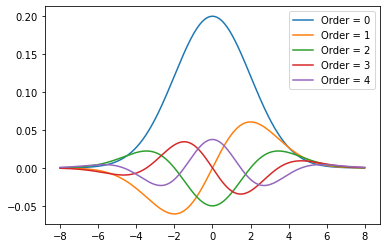

In [3]:
# A 1D Gaussian with scale s. 
def g1d(s, x):
    '''A 1D, zero-mean Gaussian function with scale s'''
    norm = 1.0 / (s * np.sqrt(2.0 * np.pi))
    return norm * np.exp(-(x ** 2.0) / (2.0 * s ** 2.0))

# 1D Gaussian derivatives of order ox at scale sigma=s.
def gd1d(ox, s, x):
    '''1D Gaussian derivative of order ox at scale s computed using the Hermite polynomials.'''
    return (-1.0 / (s * np.sqrt(2))) ** ox * hermite(ox, (-x / (s * np.sqrt(2.0)))) * g1d(s, x)

# Some tests.
rng = np.arange(-8, 8, 0.01)
for ox in range(5):
    plt.plot(rng, gd1d(ox, 2.0, rng))
plt.legend([f'Order = {o}' for o in range(5)])

Those basis functions look pretty convincing. But we will need to discretize them to use as filters:

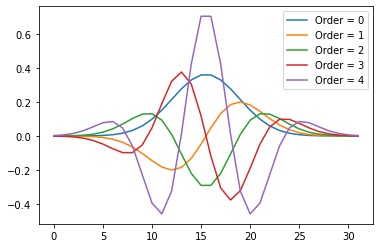

In [4]:
# Discretizes a 1D Gaussian by sampling size points in [-limit, +limit]. 
def discrete_gd1d(ox, s=1.1, limit=5.0, size=32):
    '''Discretizes order ox, scale s Gaussian derivative by sampling size points in [-limit, +limit].'''
    return gd1d(ox, s, np.linspace(-limit, +limit, size))[:,None]

# Test discretizations.
for ox in range(5):
    plt.plot(discrete_gd1d(ox))
plt.legend([f'Order = {o}' for o in range(5)])

Well, those are significantly more crappy, but will probably be OK.

# The 2D Gaussian derivative basis for images.

There is probably a better way to do this, but I always use an impulse function at (0,0) convolved with Gaussian derivative filters (i.e. a **copy** of the filter at the center of the image). The filters are separable, so we can perform two 1D convolutions of the 2D impulse to get the result.

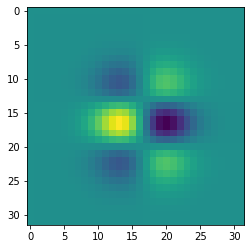

In [5]:
# A 1.0 at the center of image.
def impulse(size=32):
    '''A discretized impulse of 1.0 at the center of image of given size.'''
    ret = np.zeros((size,size))
    ret[size//2, size//2] = 1.0
    return ret

# Generate 2D Gaussian derivative order (ox, oy), scale s, at given size.
def gd2d(ox, oy, s=1.1, size=32):
    '''Generate discrete 2D Gaussian derivative order (ox, oy), scale s, at given size.'''
    return convolve2d(convolve2d(impulse(),discrete_gd1d(oy, s, size=size), mode='same'),
                      discrete_gd1d(ox, s, size=size).T, mode='same')

# Visualize a random Gaussian derivatives.
plt.imshow(gd2d(1, 2))

These images generated by `gd2d` will be our 2D basis functions for generating more complex images. Let's visualize 16 of them:

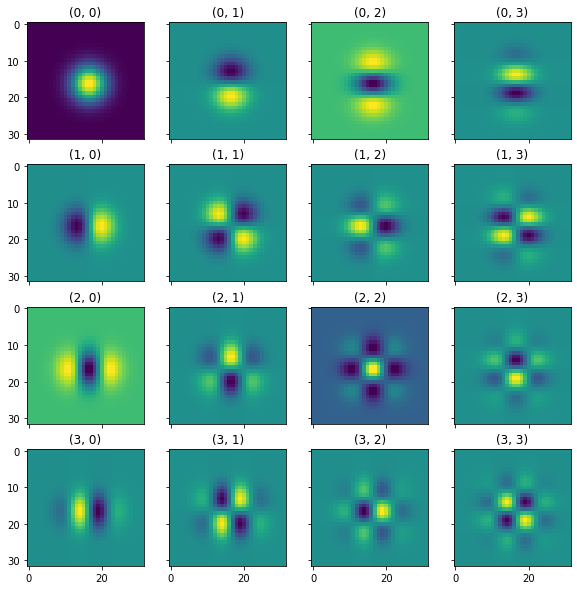

In [6]:
# Generate the basis images for all combinations of orders up to 3.
orders = [(ox, oy) for ox in range(4) for oy in range(4)]
basis = [gd2d(ox, oy) for (ox, oy) in orders]
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.35)
for (ax, im, (ox, oy)) in zip(grid, basis, orders):
    ax.imshow(im)
    ax.set_title(f'{(ox, oy)}')

# Random image generation

First we will stack these basis images into a tensor so we can generate images just by dotting the basis with a vector of coefficients:

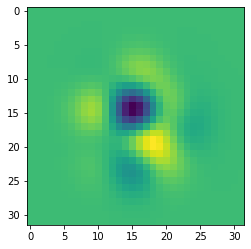

In [7]:
# Stack the individual basis images into a single tensor.
basis_tensor = np.stack(basis, axis=-1)

# Generate a random image using the basis.
def rand_image():
    return np.dot(basis_tensor, np.random.normal(size=(16,)))

# Show one...
plt.imshow(rand_image())

Now generate a grid of random images just to see how distinct they are:

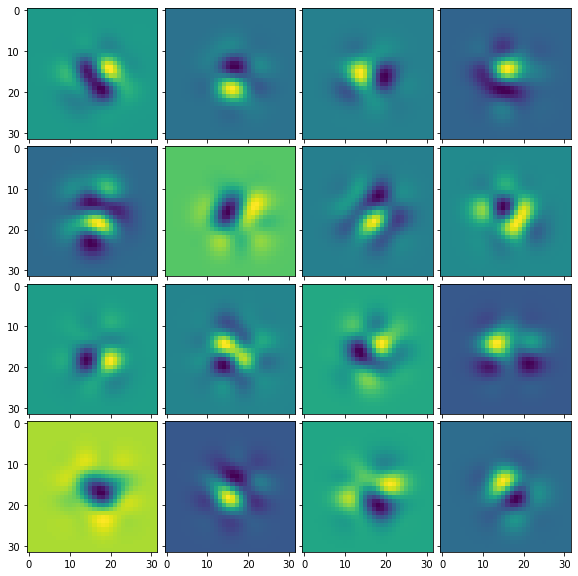

In [8]:
coefficients = np.random.normal(size=(16, 16))
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)
for (ax, c) in zip(grid, coefficients):
    ax.imshow(np.dot(basis_tensor, c))

OK, but our real goal is to use a single coefficient vector and randomly perturb it with additive Gaussian noise to generate instances of the same "class":

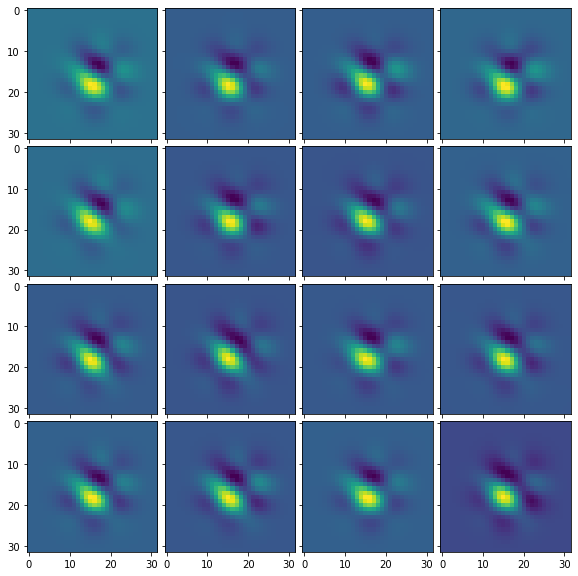

In [9]:
# Now we can generate small perturbations of a coefficient vector to generate samples
# from the "class" represented by it.
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)
for ax in grid:
    c = coefficients[13] + np.random.normal(size=c.shape, scale=0.2)
    ax.imshow(np.dot(basis_tensor, c))

Note that, even though these images look very similar, the contrast stretching from `imshow` hides a lot of the real variation...

# Generating classes of color images

Now let's put everything together into an image class generator:

In [10]:
# From a list of mean coefficient vectors (R, G, B), generate a random image by purturbing
# each coefficient vector with additive Gaissian Noise.
def sample_class(means, s=0.2):
    ims = [np.dot(basis_tensor, m + np.random.normal(scale=s)) for m in means]
    return np.stack(ims, axis=-1)

Let's test this with a grid of samples from a random, fixed class mean:

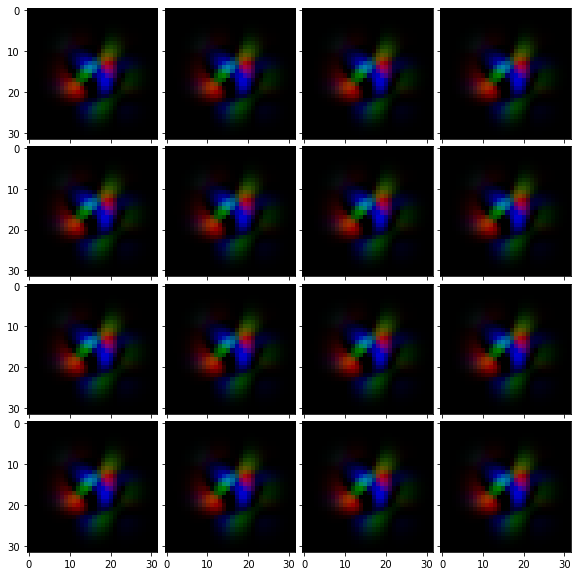

In [11]:
import logging

# Matplotlib sucks.
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

# Use fixed, random mean coefficient vectors for each channel.
means = [np.random.normal(scale=2.0, size=(16,)) for _ in range(3)]
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)
for ax in grid:
    im = sample_class(means, s=0.1)
    ax.imshow(im)

# Matplotlib sucks.
logger.setLevel(old_level)

# Discriminability test

OK, now let's generate samples from ten classes and see if we can classify them:

In [12]:
# Generate 100 samples from 10 classes.
Xs = []
ys = []
for c in range(10):
    means = [np.random.normal(scale=2.0, size=(16,)) for _ in range(3)]
    Xs.append([sample_class(means, s=0.2) for _ in range(100)])
    ys.append(c * np.ones(shape=(100,)))
Xs = np.vstack(Xs).reshape(1000, -1)
ys = np.hstack(ys)

Now split the data and train an SVM:

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Split into train and test.
(Xtr, Xte, ytr, yte) = train_test_split(Xs, ys, train_size=0.75)

# Try an SVM, because I'm lazy.
model = SVC()
model.fit(Xtr, ytr)
print(classification_report(yte, model.predict(Xte)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        22
         1.0       1.00      1.00      1.00        20
         2.0       1.00      1.00      1.00        22
         3.0       1.00      1.00      1.00        27
         4.0       1.00      1.00      1.00        22
         5.0       1.00      1.00      1.00        24
         6.0       1.00      1.00      1.00        30
         7.0       1.00      1.00      1.00        24
         8.0       1.00      1.00      1.00        30
         9.0       1.00      1.00      1.00        29

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



# Thoughts

Classification works great, even without guaranteeing separation or orthogonality of the class coefficients.

The images are very "blobby", which is to be expected since we are generating using relatively large $\sigma$ Gaussians convolved with a **single** impulse function. This should mean that in a CNN, the features higher in the network (i.e. low-frequency ones) should be more discriminative. I don't know what this might mean in terms of continual learning.

We have a lot of knobs we can use to control generation of image: the $\sigma$ of the Gaussians used to generate the stack of basis images, the size of the basis (right now 16 images, but we could go to 25, or less, by varying the degrees of Gaussian derivatives), plus the scale of the Gaussian noise used to generate instances of random classes.